In [8]:
import yfinance as yf
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
from scipy.optimize import _minimize
import matplotlib.pyplot as plt
end_date=datetime.today()
start_date=end_date-timedelta(days=38*365)
data=yf.download('MSFT',start=start_date)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-11-28,0.175347,0.176215,0.171007,0.172743,0.106512,41328000
1986-12-01,0.172743,0.173611,0.168403,0.169271,0.104371,40291200
1986-12-02,0.170139,0.173611,0.170139,0.170139,0.104907,28771200
1986-12-03,0.170139,0.171875,0.168403,0.168837,0.104104,35164800
1986-12-04,0.168837,0.172743,0.167535,0.171007,0.105442,42508800
...,...,...,...,...,...,...
2024-11-11,422.519989,424.809998,416.000000,418.010010,418.010010,24503300
2024-11-12,418.250000,424.440002,417.200012,423.029999,423.029999,19401200
2024-11-13,421.640015,429.329987,418.209991,425.200012,425.200012,21502200


In [9]:
data= data[['Close']]
data

,Close
Date,
1986-11-28,0.172743
1986-12-01,0.169271
1986-12-02,0.170139
1986-12-03,0.168837
1986-12-04,0.171007
...,...
2024-11-11,418.010010
2024-11-12,423.029999
2024-11-13,425.200012


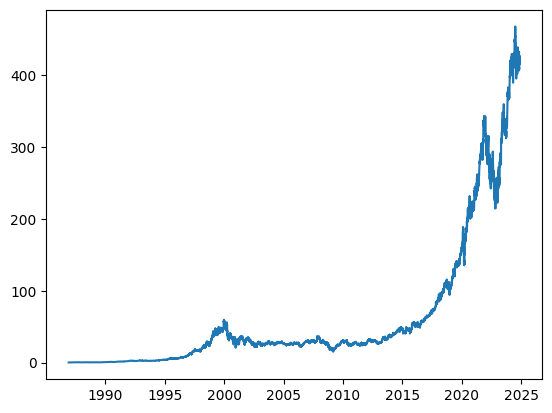

In [ ]:
plt.plot(data.index,data['Close'])

In [12]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [14]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(data, 
                                '2022-03-25', 
                                '2023-03-23', 
                                n=4)
windowed_df

,Target Date,Target-4,Target-3,Target-2,Target-1,Target
0,2022-03-25,299.160004,304.059998,299.489990,304.100006,303.679993
1,2022-03-28,304.059998,299.489990,304.100006,303.679993,310.700012
2,2022-03-29,299.489990,304.100006,303.679993,310.700012,315.410004
3,2022-03-30,304.100006,303.679993,310.700012,315.410004,313.859985
4,2022-03-31,303.679993,310.700012,315.410004,313.859985,308.309998
...,...,...,...,...,...,...
245,2023-03-17,253.919998,260.790009,265.440002,276.200012,279.429993
246,2023-03-20,260.790009,265.440002,276.200012,279.429993,272.230011
247,2023-03-21,265.440002,276.200012,279.429993,272.230011,273.779999
248,2023-03-22,276.200012,279.429993,272.230011,273.779999,272.290009


In [15]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)


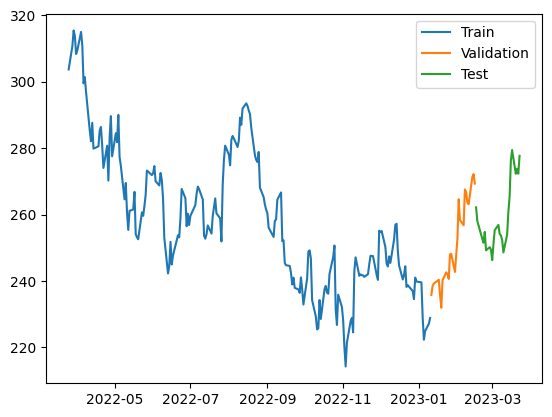

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((4, 1)),
                    layers.LSTM(512),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100
7/7 [==============================] - 2s 97ms/step - loss: 66303.7734 - mean_absolute_error: 256.6018 - val_loss: 60428.9805 - val_mean_absolute_error: 245.4948
Epoch 2/100
7/7 [==============================] - 0s 36ms/step - loss: 62869.6914 - mean_absolute_error: 249.7793 - val_loss: 55052.3633 - val_mean_absolute_error: 234.2807
Epoch 3/100
7/7 [==============================] - 0s 37ms/step - loss: 55460.2656 - mean_absolute_error: 234.3566 - val_loss: 43949.5156 - val_mean_absolute_error: 209.2191
Epoch 4/100
7/7 [==============================] - 0s 38ms/step - loss: 40678.6211 - mean_absolute_error: 199.8918 - val_loss: 23536.7578 - val_mean_absolute_error: 152.7739
Epoch 5/100
7/7 [==============================] - 0s 37ms/step - loss: 17633.2266 - mean_absolute_error: 128.1680 - val_loss: 3446.0298 - val_mean_absolute_error: 57.1747
Epoch 6/100
7/7 [==============================] - 0s 38ms/step - loss: 1912.2437 - mean_absolute_error: 35.7399 - val_loss: 2297.99

7/7 [==============================] - 0s 4ms/step


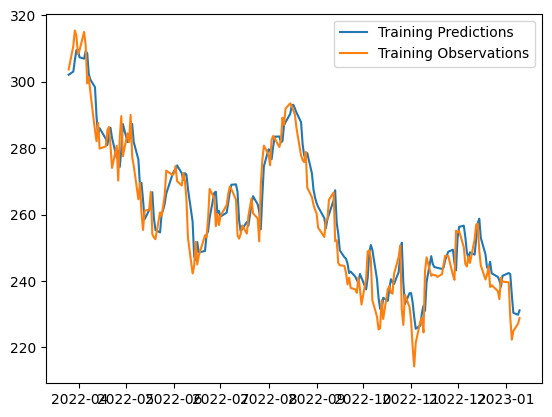

In [22]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 20ms/step


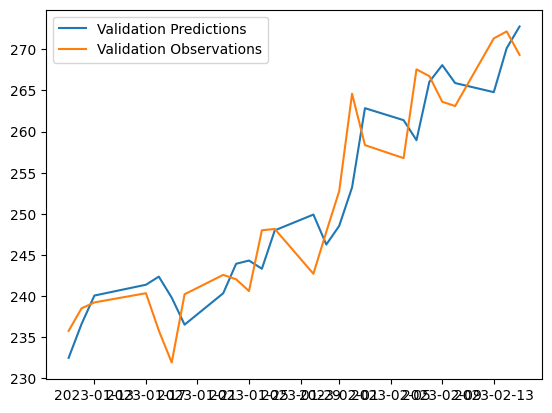

In [23]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 20ms/step


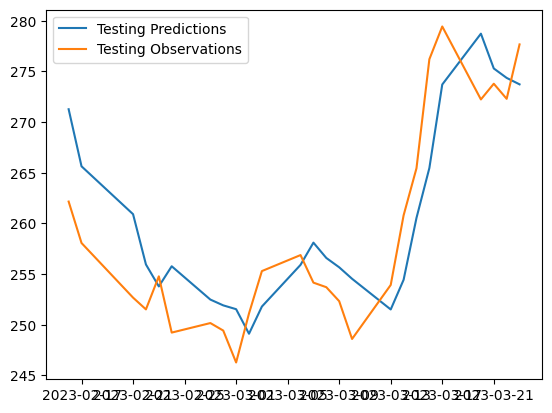

In [25]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])